## MVA (Mean Value Analysis) Exact Algorithm
The exact **Mean Value Analysis (MVA)** algorithm is a fundamental iterative method for analyzing the performance of closed queuing networks (where there is a fixed number *N* of "customers" or "jobs" circulating).

It calculates key metrics such as *throughput*, *resonse time*, and *queue size* ($L_k(n) = X(n) \times R_k(n)$) for each service station (device).*

The algorithm is based on two main ideas: 
- **The Arrival Theorem**: In a closed network with *n* clients, a client arriving at a station "sees" the system as if it were in equilibrium with *n-1* clients. $R_k(n) = S_k \times (1 + L_k(n-1))$
- **Little's Law**: Applied to the entire system and to each station individually. $X(n) = \frac{n}{Z + \sum_{k=1}^{M} R_k(n)}$

``mva_exato(N: int, S: list[float], Z: float = 0.0, print_table=True)``: Calculates the performance of a closed queuing network using Exact MVA for a single customer class.

Arguments:
- N (int): The total number of customers (jobs) in the network.
- S (list): A list of service times (S_k) for each k-station. The length of the list is the number of stations (K).
- Z (float): The "think time" of the customers. The default is 0.
- print_table(bool): Show a table with each iteration.

Returns: A dictionary containing the final results (for N customers):
- 'X': System throughput
- 'R': List of residence/response times (R_k) for each station
- 'Q': List of average queue sizes (Q_k) for each station
- 'U': List of utilization (U_k) for each station

In [ ]:
! pip install pandas numpy seaborn matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from modules.MVA import mva_aproximado_bard, mva_exato
from modules.asymptoticLimits import plot_performance_graphs
from modules.markovChain import calculate_system_performance_markov


## Approximate MVA (Mean Value Analysis) or Bard-Schweitzer Algorithm
The exact **Approximate Mean Value Analysis (MVA)** algorithm provides a computationally efficient alternative to the exact Mean Value Analysis (MVA) algorithm. This is especially true for multiclass networks, where the exact MVA becomes complex. In these cases, storage requirements grow exponentially with the number of customer classes.

The core of the approximation relies on the assumption that the **probability** of a **customer arriving** at a specific queue is **proportional** to the **overall mean queue length** of other customers in that queue. This excludes the arriving customer. This simplifies the calculation of queue lengths at arrival instants. 

The exact MVA is great, but its complexity is $O(N \times M)$, where $N$ is the number of customers and $M$ is the number of centers. If $N$ is very large (thousands or millions), the exact algorithm becomes computationally infeasible, as it requires $N$ iterations. So, the great advantage is that this algorithm converges very quickly (usually in a few iterations) and its complexity does not depend on $N$ (except for the factor $\frac{N-1}{N}$). The complexity of each iteration is only $O(M)$.

``mva_aproximado_bard(N: int, M: int, S: list[float], Z: float = 0.0, max_iter: int = 1000, tol: float = 1e-6, print_table: bool = True)``: Calculates the approximate MVA (Mean Value Analysis) using the Bard-Schweitzer algorithm (fixed-point iteration).

Arguments:

- N (int): The total number of clients (jobs) in the network.
- M (int): The number of service centers (e.g., CPU, Disk).
- S (list[float]): A list of average service times [S_1, S_2, ..., S_M].
- Z (float): The average "think time". Default is 0.0.
- max_iter (int): Maximum number of iterations for convergence.
- tol (float): Tolerance for the stopping criterion.

Returns:
- dict: A dictionary containing the performance metrics for N clients.


In [2]:
# ---------------------------- PLOTS -------------------------------------
def plot_graphs_mva(S_demandas: list[float], N_max: int, 
                    Z_think: float, tol_aprox: float, filename: str):
    M_recursos = len(S_demandas)

    # --- Listas para armazenar resultados ---
    n_values = range(1, N_max + 1)
    print(f"Iniciando coleta de dados até N={N_max}...")

    # --- MVA Exato ---
    res_exato = mva_exato(N_max, S_demandas, Z_think, print_table=False)
    exact_X = res_exato['history_X']
    exact_R = res_exato['history_R_total']
    print("MVA Exato concluído.")

    # --- MVA Aproximado ---
    approx_X = []
    approx_R = []
    for n in n_values:
        res_aprox = mva_aproximado_bard(
            n, M_recursos, S_demandas, Z_think, 
            tol=tol_aprox, print_table=False
        )
        approx_X.append(res_aprox['X'])
        approx_R.append(res_aprox['R_total'])
    print("MVA Aproximado concluído.")

    print("Gerando gráficos...")
    plt.figure(figsize=(10, 10))

    # --- Throughput (X) vs. N  ---
    plt.plot(n_values, exact_X, 'b-', label='MVA Exato (X)', linewidth=2)
    plt.plot(n_values, approx_X, 'r--o', label='MVA Aprox. (X)', markersize=4)
    D_max = max(S_demandas)
    X_assintotico = 1.0 / D_max
    plt.axhline(y=X_assintotico, color='gray', linestyle=':', 
                label=f'Assíntota X_max = {X_assintotico:.2f}')
    plt.title('Throughput (X) vs. Número de Usuários (N)', fontsize=14)
    plt.xlabel('Número de Usuários (N)', fontsize=12)
    plt.ylabel('Throughput (transações/s)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'./outputs/mva_comparacao_{filename}_x_n.png')

    # --- Tempo de Resposta (R) vs. N  ---
    plt.figure(figsize=(10, 10))
    plt.plot(n_values, exact_R, 'b-', label='MVA Exato (R)', linewidth=2)
    plt.plot(n_values, approx_R, 'r--o', label='MVA Aprox. (R)', markersize=4)
    D_total = sum(S_demandas)
    R_assintotico_line = [(n / X_assintotico) - Z_think for n in n_values]
    plt.plot(n_values, R_assintotico_line, color='gray', linestyle=':', 
            label=f'Assíntota R = N/X_max - Z')
    plt.axhline(y=D_total, color='lightgray', linestyle=':', 
                label=f'Mínimo R_min = {D_total:.2f}')
    plt.title('Tempo de Resposta (R) vs. Número de Usuários (N)', fontsize=14)
    plt.xlabel('Número de Usuários (N)', fontsize=12)
    plt.ylabel('Tempo de Resposta (s)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'./outputs/mva_comparacao_{filename}_r_n.png')

    # --- Throughput (X) vs. Tempo de Resposta (R) ---
    plt.figure(figsize=(10, 10))
    plt.plot(exact_X, exact_R, 'b-', label='MVA Exato', linewidth=2)
    plt.plot(approx_X, approx_R, 'r--o', label='MVA Aprox.', markersize=4)

    plt.plot(exact_X[0], exact_R[0], 'go', markersize=8, 
            label=f'Início (N=1)\nR={exact_R[0]:.2f}s, X={exact_X[0]:.2f} t/s')

    plt.title('Throughput (X) vs. Tempo de Resposta (R)', fontsize=14)
    plt.xlabel('Throughput (transações/s)', fontsize=12)
    plt.ylabel('Tempo de Resposta (s)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Salvar e Mostrar ---
    plt.tight_layout()
    plt.savefig(f'./outputs/mva_comparacao_{filename}_x_r.png')

In [ ]:
"""
4. Um sistema computacional tem uma CPU e dois discos. O sistema foi monitorado 
durante 1 hora e a utilização da CPU e do disco A foram 32% e 60%, 
respectivamente. Cada transação faz 5 operações de I/O no disco A e 8 operações 
de I/O no disco B. O tempo médio de serviço no disco A é 30 ms e no disco B 25 ms. 
Encontre:

• Throughput do sistema;
• Utilização do disco B;
• Demandas dos recursos;
• Tempo médio de resposta e número de instruções nos recursos quando N = 10.

"""

# -------------------------- Parâmetros da Questão 4  --------------------------
U_cpu = 0.32
U_disco_a = 0.60

V_disco_a = 5
V_disco_b = 8
V_cpu = 1 + V_disco_a + V_disco_b

S_disco_a = 0.030
S_disco_b = 0.025

# • Throughput do sistema;
X = U_disco_a / (V_disco_a * S_disco_a)  # $U_A = X \times V_A \times S_A$

# • Demandas dos recursos;
D_disco_a = V_disco_a * S_disco_a   # $D_k = V_k \times S_k$
D_disco_b = V_disco_b * S_disco_b
D_cpu = U_cpu / X        # Lei da Utilização: $U_{CPU} = X \times D_{CPU}$
S_cpu = D_cpu / V_cpu    # Lei da Demanda

# • Utilização do disco B;
U_disco_b = X * D_disco_b

N_transacoes_questao_4 = 10                           # jobs
M_recursos_questao_4 = 3                              # Recursos
Z_think_time_questao_4 = 0                            # Sistema batch
S_questao_4 = [D_cpu, D_disco_a, D_disco_b]

metricas_questao_4 = mva_exato(
    N=N_transacoes_questao_4, 
    S=S_questao_4, 
    Z=Z_think_time_questao_4
)

print(f"--- Resultados do MVA para N = {N_transacoes_questao_4} ---")
print(f"Throughput total (X): {metricas_questao_4['X']:.4f} trans/s")
print(f"Tempo de Resposta do Sistema (R): {metricas_questao_4['R_total']:.4f} s\n")

print("--- Métricas por Recurso ---")
recursos_questao_4 = ['CPU', 'Disco A', 'Disco B']
for i in range(M_recursos_questao_4):
    print(f"  Recurso: {recursos_questao_4[i]}")
    print(f"    Tempo de Resposta (R_{i}): {metricas_questao_4['R_k'][i]:.4f} s")
    print(f"    Nº médio de transações (N_{i}): {metricas_questao_4['N_k'][i]:.4f}\n")



--- Tabela MVA Exato (N=10, Z=0) ---
 n |   X(n)  | R_total | R_1     | R_2     | R_3     | N_1     | N_2     | N_3    
----------------------------------------------------------------------------
1  | 2.3256  | 0.4300  | 0.0800  | 0.1500  | 0.2000  | 0.1860  | 0.3488  | 0.4651 
2  | 3.3885  | 0.5902  | 0.0949  | 0.2023  | 0.2930  | 0.3215  | 0.6856  | 0.9929 
3  | 3.9623  | 0.7571  | 0.1057  | 0.2528  | 0.3986  | 0.4189  | 1.0018  | 1.5793 
4  | 4.3027  | 0.9296  | 0.1135  | 0.3003  | 0.5159  | 0.4884  | 1.2920  | 2.2196 
5  | 4.5176  | 1.1068  | 0.1191  | 0.3438  | 0.6439  | 0.5379  | 1.5531  | 2.9090 
6  | 4.6591  | 1.2878  | 0.1230  | 0.3830  | 0.7818  | 0.5732  | 1.7843  | 3.6425 
7  | 4.7554  | 1.4720  | 0.1259  | 0.4176  | 0.9285  | 0.5985  | 1.9861  | 4.4154 
8  | 4.8225  | 1.6589  | 0.1279  | 0.4479  | 1.0831  | 0.6167  | 2.1601  | 5.2232 
9  | 4.8702  | 1.8480  | 0.1293  | 0.4740  | 1.2446  | 0.6299  | 2.3085  | 6.0616 
10 | 4.9044  | 2.0390  | 0.1304  | 0.4963  | 1.4123  | 

In [ ]:
"""
5. Para um sistema timesharing com dois discos, as probabilidades para as solicitações 
completarem serviço da CPU para o Disco A foram 80% , para o Disco B, 16%, e para os
terminais 4% (término de uma solicitação e envio da resposta para o terminal 
solicitante). O tempo de pensar é de 5 segundos. O tempo de serviço no Disco A é 
de 30 milissegundos e no Disco B de 25 milissegundos, o tempo médio de serviço na 
CPU é de 40 milissegundos. Construa um modelo QN para esse problema e responda:

# -------- para fazer com o algoritmo MVA ----------

(j) Utilize MVA para calcular o throughput do sistema para 30 usuários interativos.

(k) Utilize a aproximação de Schweitzer para o MVA com N = 30 usuários e ϵ = 0.001.

"""

# -------------------------- Parâmetros da Questão 5  --------------------------
# Letra (j)
prob_disco_a = 0.8
prob_disco_b = 0.16
prob_terminais = 0.04

V_cpu = 1 / prob_terminais
V_disco_a = V_cpu * prob_disco_a
V_disco_b = V_cpu * prob_disco_b

U_cpu = 0.32
U_disco_a = 0.60
S_disco_a = 0.030
S_disco_b = 0.025
S_cpu = 0.040

D_cpu = V_cpu * S_cpu
D_disco_a = V_disco_a * S_disco_a
D_disco_b = V_disco_b * S_disco_b


N_transacoes_questao_5_j = 30       # jobs
M_recursos_questao_5_j = 3          # Recursos
Z_think_time_questao_5_j = 5
S_questao_5_j = [D_cpu, D_disco_a, D_disco_b]

metricas_questao_5 = mva_exato(
    N=N_transacoes_questao_5_j,
    S=S_questao_5_j, 
    Z=Z_think_time_questao_5_j)

print(f"--- Resultados do MVA para N = {N_transacoes_questao_5_j} ---")
print(f"Throughput total (X): {metricas_questao_5['X']:.4f} trans/s")
print(f"Tempo de Resposta do Sistema (R): {metricas_questao_5['R_total']:.4f} s\n")

print("--- Métricas por Recurso ---")
recursos_questao_5_j = ['CPU', 'Disco A', 'Disco B']

for i in range(M_recursos_questao_5_j):
    print(f"  Recurso: {recursos_questao_5_j[i]}")
    print(f"    Tempo de Resposta (R_{i}): {metricas_questao_5['R_k'][i]:.4f} s")
    print(f"    Nº médio de transações (N_{i}): {metricas_questao_5['N_k'][i]:.4f}\n")



--- Tabela MVA Exato (N=30, Z=5) ---
 n |   X(n)  | R_total | R_1     | R_2     | R_3     | N_1     | N_2     | N_3    
----------------------------------------------------------------------------
1  | 0.1493  | 1.7000  | 1.0000  | 0.6000  | 0.1000  | 0.1493  | 0.0896  | 0.0149 
2  | 0.2897  | 1.9045  | 1.1493  | 0.6537  | 0.1015  | 0.3329  | 0.1894  | 0.0294 
3  | 0.4196  | 2.1495  | 1.3329  | 0.7136  | 0.1029  | 0.5593  | 0.2994  | 0.0432 
4  | 0.5374  | 2.4433  | 1.5593  | 0.7797  | 0.1043  | 0.8380  | 0.4190  | 0.0561 
5  | 0.6414  | 2.7950  | 1.8380  | 0.8514  | 0.1056  | 1.1789  | 0.5461  | 0.0677 
6  | 0.7305  | 3.2134  | 2.1789  | 0.9277  | 0.1068  | 1.5917  | 0.6777  | 0.0780 
7  | 0.8040  | 3.7062  | 2.5917  | 1.0066  | 0.1078  | 2.0838  | 0.8093  | 0.0867 
8  | 0.8622  | 4.2781  | 3.0838  | 1.0856  | 0.1087  | 2.6590  | 0.9361  | 0.0937 
9  | 0.9063  | 4.9300  | 3.6590  | 1.1616  | 0.1094  | 3.3163  | 1.0528  | 0.0991 
10 | 0.9383  | 5.6579  | 4.3163  | 1.2317  | 0.1099  | 

In [ ]:
# -------------------------- Parâmetros da Questão 5  --------------------------
# Letra (k)
prob_disco_a = 0.8
prob_disco_b = 0.16
prob_terminais = 0.04

V_cpu = 1 / prob_terminais
V_disco_a = V_cpu * prob_disco_a
V_disco_b = V_cpu * prob_disco_b

U_cpu = 0.32
U_disco_a = 0.60
S_disco_a = 0.030
S_disco_b = 0.025
S_cpu = 0.040

D_cpu = V_cpu * S_cpu
D_disco_a = V_disco_a * S_disco_a
D_disco_b = V_disco_b * S_disco_b


N_transacoes_questao_5_k = 30       # jobs
M_recursos_questao_5_k = 3          # Recursos
Z_think_time_questao_5_k = 5
S_questao_5_k = [D_cpu, D_disco_a, D_disco_b]
tolerancia_questao_5_k = 0.001

metricas_questao_5_aprox = mva_aproximado_bard(
    N=N_transacoes_questao_5_k,
    M=M_recursos_questao_5_k, 
    S=S_questao_5_k, 
    Z=Z_think_time_questao_5_k,
    tol=tolerancia_questao_5_k
)

print(f"--- Resultados do MVA para N = {N_transacoes_questao_5_k} ---")
print(f"Throughput total (X): {metricas_questao_5_aprox['X']:.4f} trans/s")
print(f"Tempo de Resposta do Sistema (R): {metricas_questao_5_aprox['R_total']:.4f} s\n")

print("--- Métricas por Recurso ---")
recursos_questao_5_k = ['CPU', 'Disco A', 'Disco B']

for i in range(M_recursos_questao_5_k):
    print(f"  Recurso: {recursos_questao_5_k[i]}")
    print(f"    Tempo de Resposta (R_{i}): {metricas_questao_5_aprox['R_k'][i]:.4f} s")
    print(f"    Nº médio de transações (N_{i}): {metricas_questao_5_aprox['N_k'][i]:.4f}\n")




--- Tabela MVA Aproximado (N=30, Z=5, tol=0.001) ---
Iter |   X     | R_total | R_1     | R_2     | R_3     | N_1     | N_2     | N_3    
----------------------------------------------------------------------------
1    | 1.2968  | 18.1333 | 10.6667 | 6.4000  | 1.0667  | 13.8329 | 8.2997  | 1.3833 
2    | 1.1991  | 20.0193 | 14.3718 | 5.4138  | 0.2337  | 17.2328 | 6.4916  | 0.2802 
3    | 1.1049  | 22.1506 | 17.6584 | 4.3651  | 0.1271  | 19.5116 | 4.8232  | 0.1404 
4    | 1.0574  | 23.3723 | 19.8612 | 3.3975  | 0.1136  | 21.0007 | 3.5924  | 0.1201 
5    | 1.0311  | 24.0958 | 21.3006 | 2.6836  | 0.1116  | 21.9626 | 2.7670  | 0.1151 
6    | 1.0154  | 24.5465 | 22.2305 | 2.2048  | 0.1111  | 22.5717 | 2.2387  | 0.1128 
7    | 1.0057  | 24.8287 | 22.8193 | 1.8984  | 0.1109  | 22.9504 | 1.9093  | 0.1115 
8    | 0.9999  | 25.0036 | 23.1854 | 1.7074  | 0.1108  | 23.1826 | 1.7072  | 0.1108 
9    | 0.9963  | 25.1108 | 23.4099 | 1.5902  | 0.1107  | 23.3238 | 1.5843  | 0.1103 
10   | 0.9942  | 25

--- Sistema Original ---
D_total (D): 1.300 s
D_max (Gargalo - CPU): 0.675 s (Recurso 1)
Tempo de Pensar (Z): 12.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 19.70


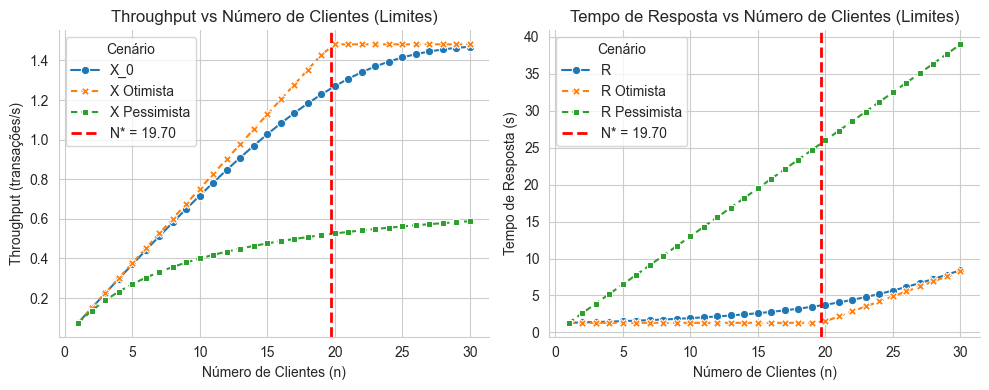

--- Modificação 1: Mover todos os arquivos para o disco rápido ---
D_total (D): 1.019 s
D_max (Gargalo - CPU): 0.675 s (Recurso 1)
Tempo de Pensar (Z): 12.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 19.29


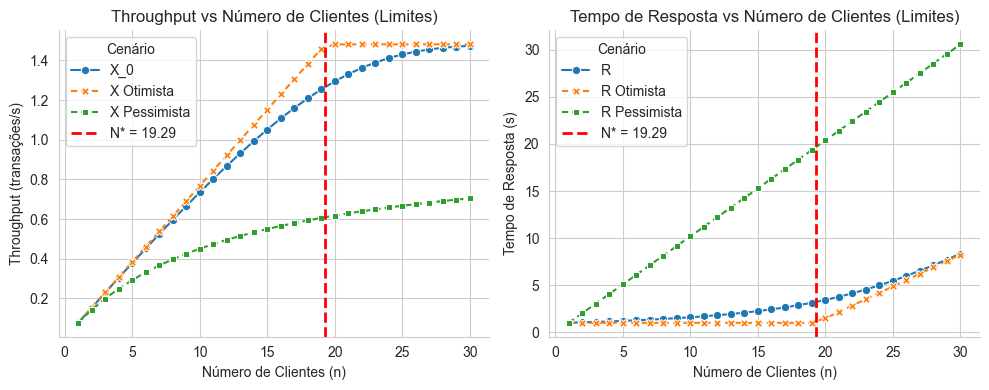

--- Modificação 2: Trocar o disco lento por um segundo disco rápido ---
D_total (D): 1.019 s
D_max (Gargalo - CPU): 0.675 s (Recurso 1)
Tempo de Pensar (Z): 12.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 19.29


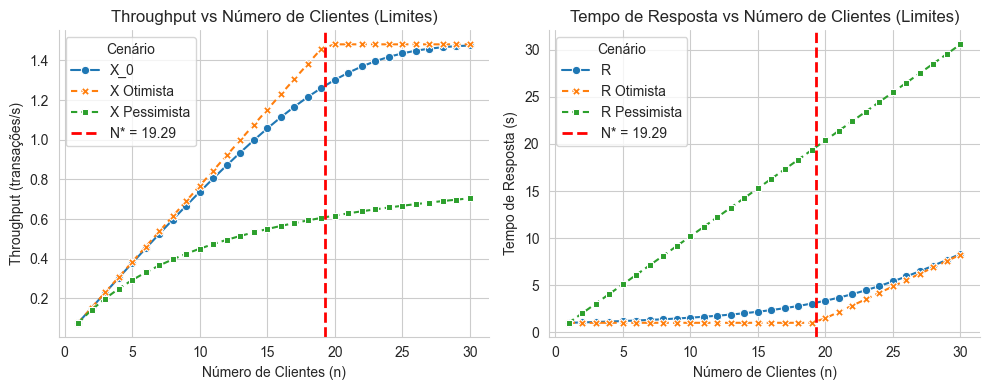

--- Modificação 3: Aumentar a velocidade da CPU em 50% ---
D_total (D): 1.075 s
D_max (Gargalo - CPU): 0.450 s (Recurso 1)
Tempo de Pensar (Z): 12.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 29.06


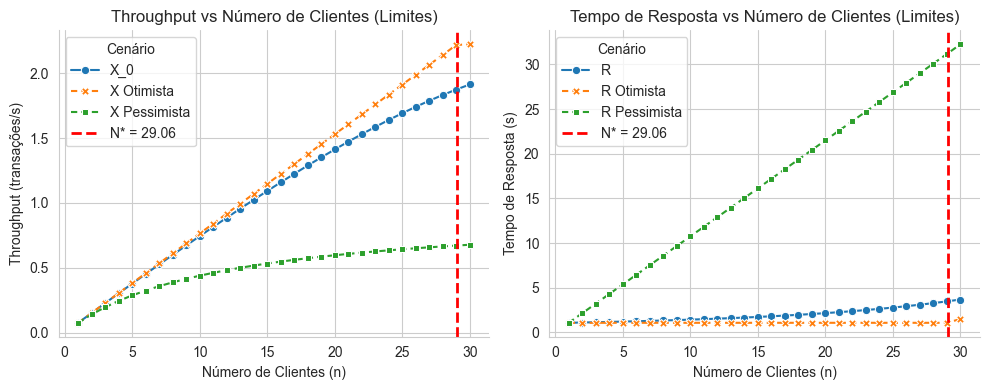

--- Modificação 4: CPU 50% + Rápida e balancear a carga dos discos ---
D_total (D): 0.794 s
D_max (Gargalo - CPU): 0.450 s (Recurso 1)
Tempo de Pensar (Z): 12.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 28.43


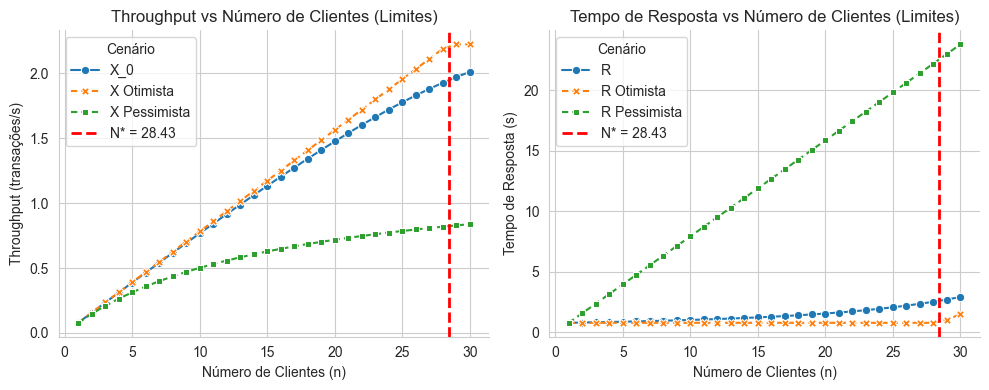

In [ ]:
# ------------------- PLOTS EXEC LISTA 3 --------------------------
# Parâmetros Globais
N_TERMINAIS = 30
Z_PENSAR = 12.0

# --- Sistema Original ---
print("--- Sistema Original ---")
D_orig = [0.675, 0.25, 0.375]
mva_orig = mva_exato(N_TERMINAIS, D_orig, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_orig, 
    D_orig, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Sistema Original")

# --- Modificação 1: Mover todos os arquivos para o disco rápido ---
print("--- Modificação 1: Mover todos os arquivos para o disco rápido ---")
D_mod1 = [0.675, 0.34375]
mva_mod1 = mva_exato(N_TERMINAIS, D_mod1, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_mod1, 
    D_mod1, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Modificação 1: Tudo no Disco Rápido")

# --- Modificação 2: Trocar o disco lento por um segundo disco rápido ---
print("--- Modificação 2: Trocar o disco lento por um segundo disco rápido ---")
D_mod2 = [0.675, 0.25, 0.09375]
mva_mod2 = mva_exato(N_TERMINAIS, D_mod2, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_mod2, 
    D_mod2, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Modificação 2: Troca Disco Lento por Rápido")

# --- Modificação 3: Aumentar a velocidade da CPU em 50% ---
print("--- Modificação 3: Aumentar a velocidade da CPU em 50% ---")
D_mod3 = [0.45, 0.25, 0.375]
mva_mod3 = mva_exato(N_TERMINAIS, D_mod3, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_mod3, 
    D_mod3, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Modificação 3: CPU 50% mais Rápida")

# --- Modificação 4: CPU 50% + Rápida e balancear a carga dos discos ---
print("--- Modificação 4: CPU 50% + Rápida e balancear a carga dos discos ---")
D_mod4 = [0.45, 0.171875, 0.171875]
mva_mod4 = mva_exato(N_TERMINAIS, D_mod4, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_mod4, 
    D_mod4, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Modificação 4: CPU Rápida + Discos Balanceados")

--- Questão 4 ---
Iniciando coleta de dados até N=10...
MVA Exato concluído.
MVA Aproximado concluído.
Gerando gráficos...
--- Questão 5 letra j ---
Iniciando coleta de dados até N=30...
MVA Exato concluído.
MVA Aproximado concluído.
Gerando gráficos...
--- Questão 5 letra k ---
Iniciando coleta de dados até N=30...
MVA Exato concluído.
MVA Aproximado concluído.
Gerando gráficos...


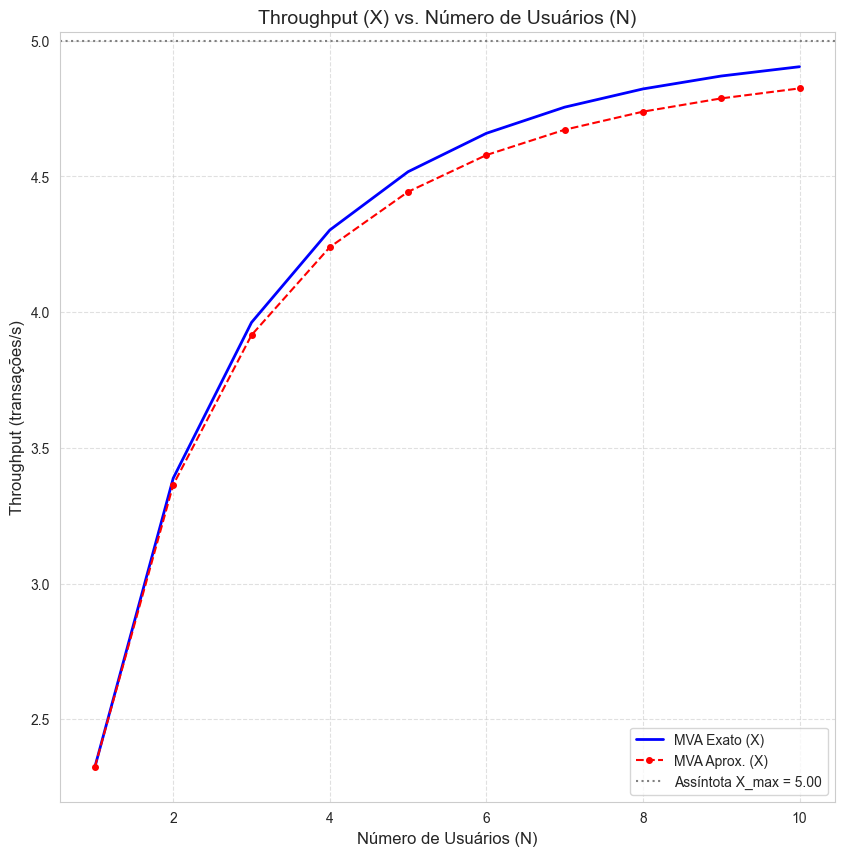

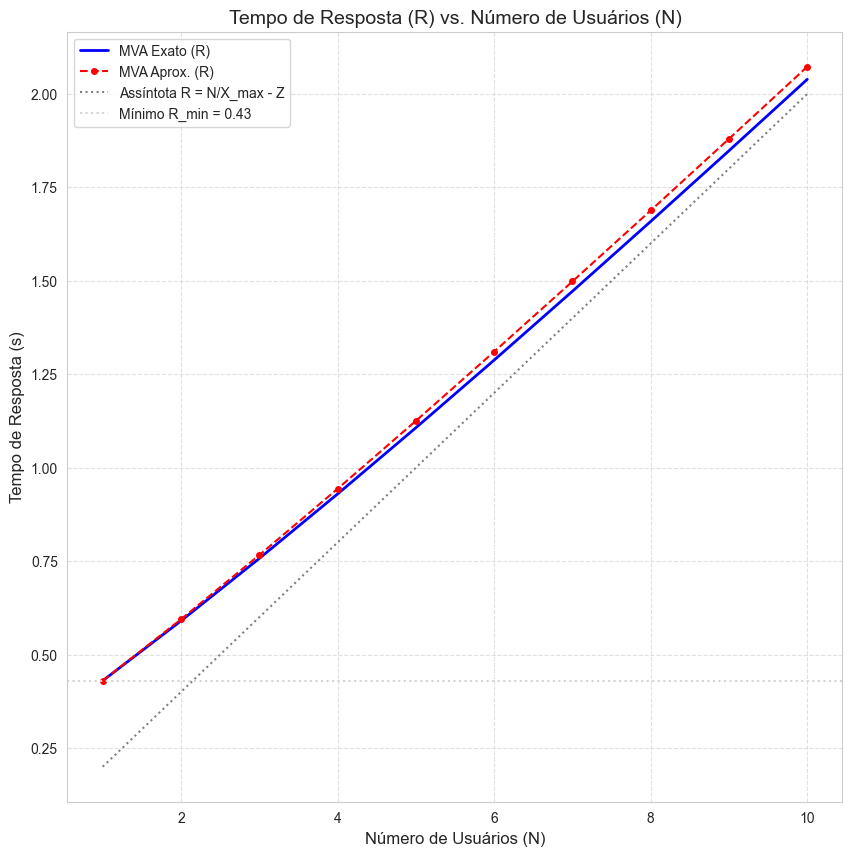

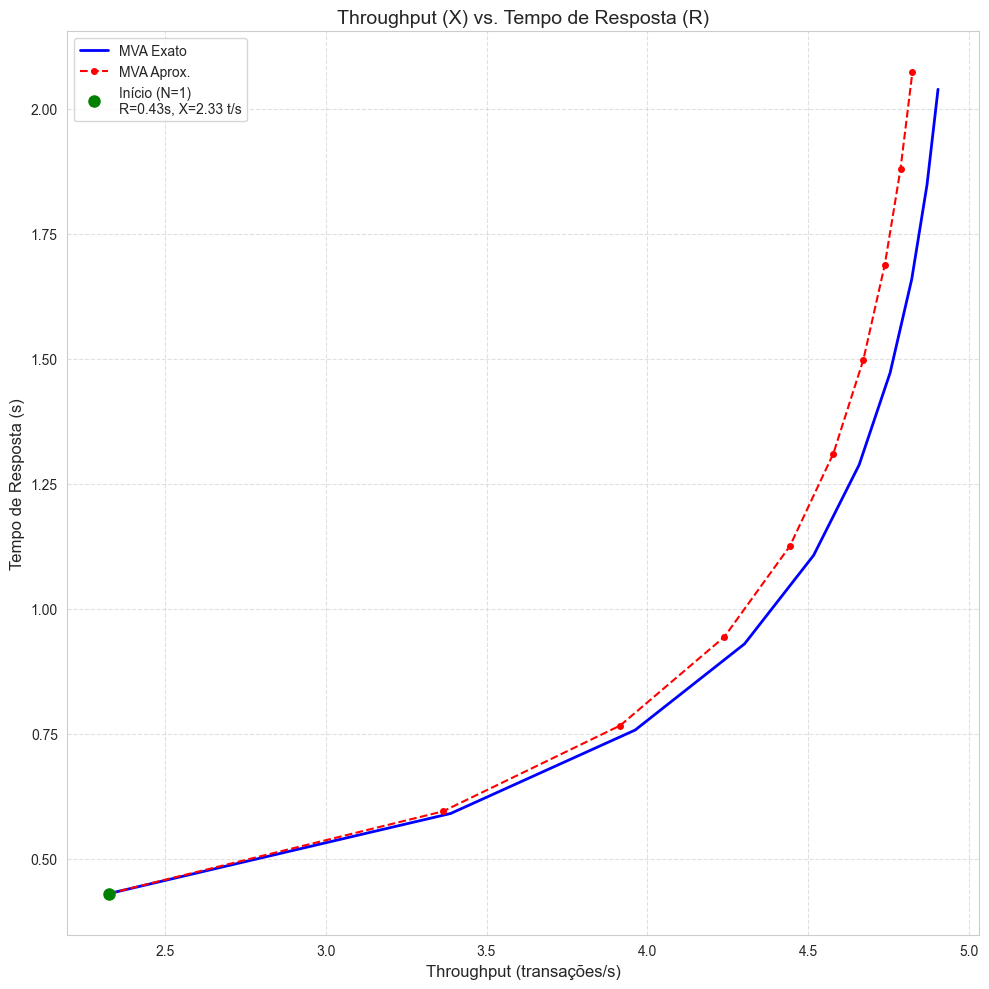

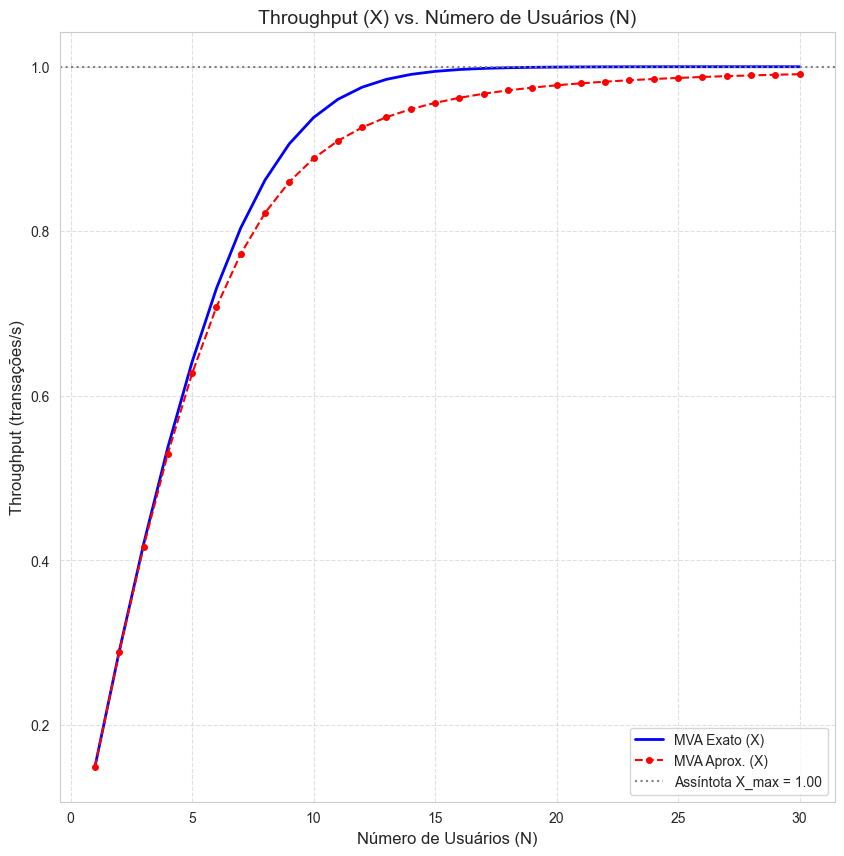

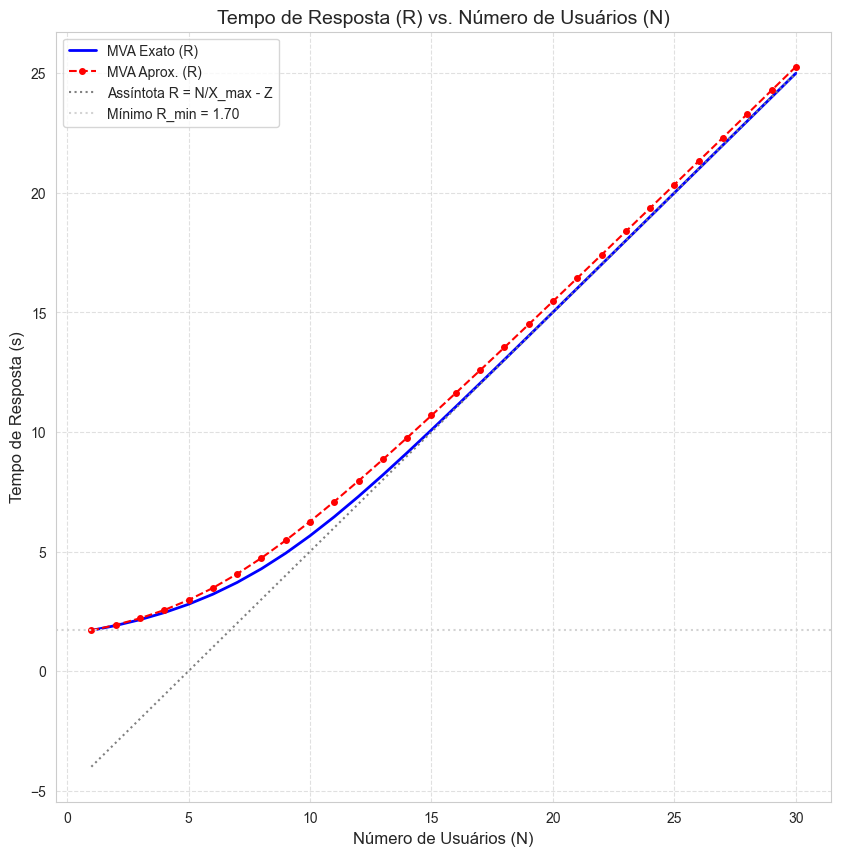

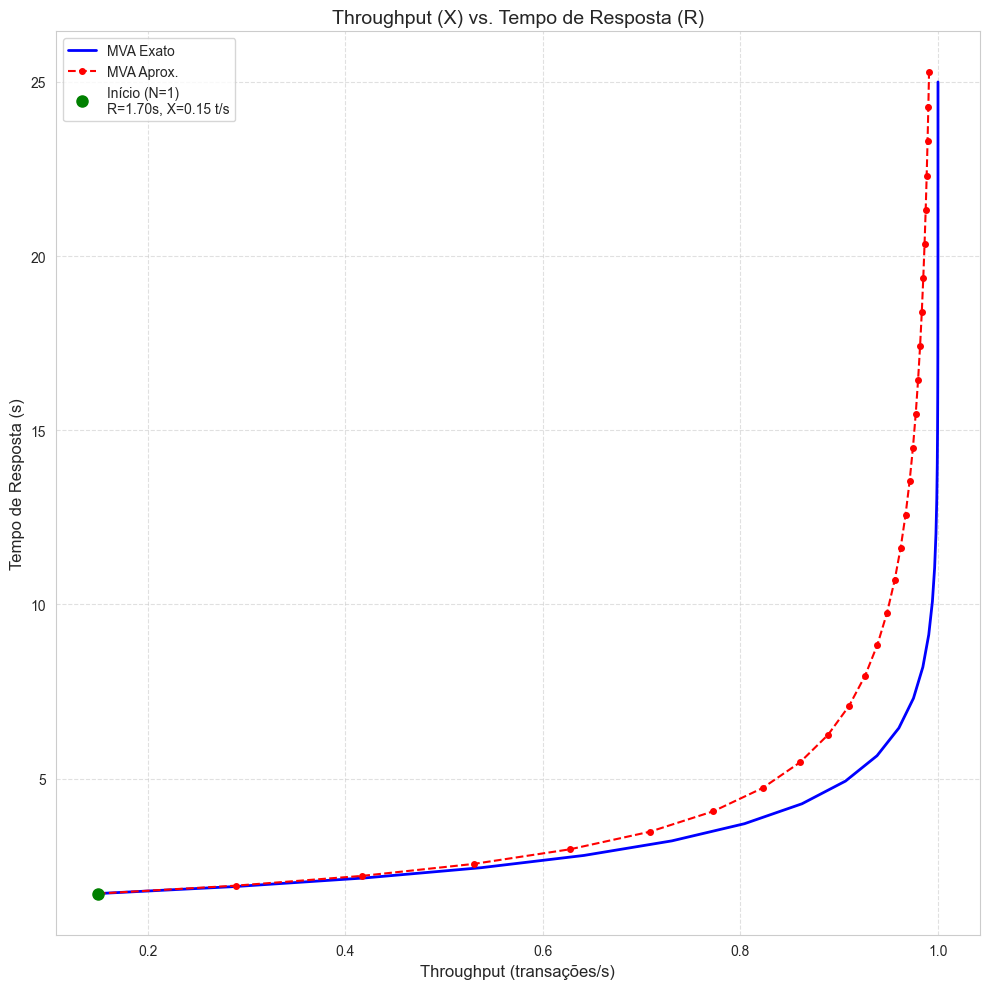

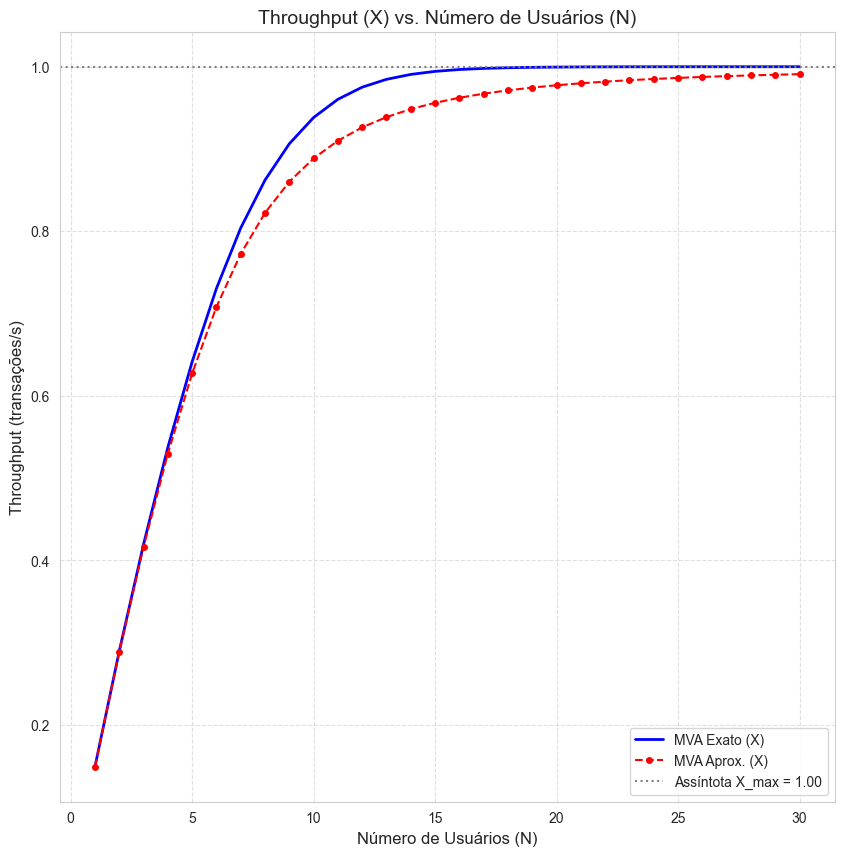

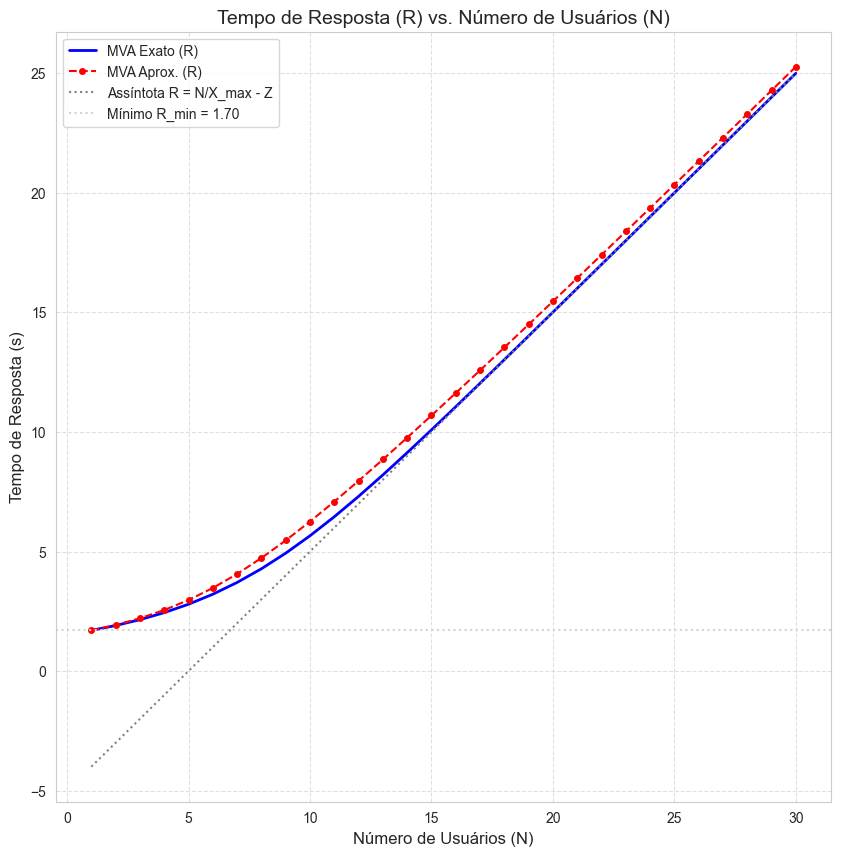

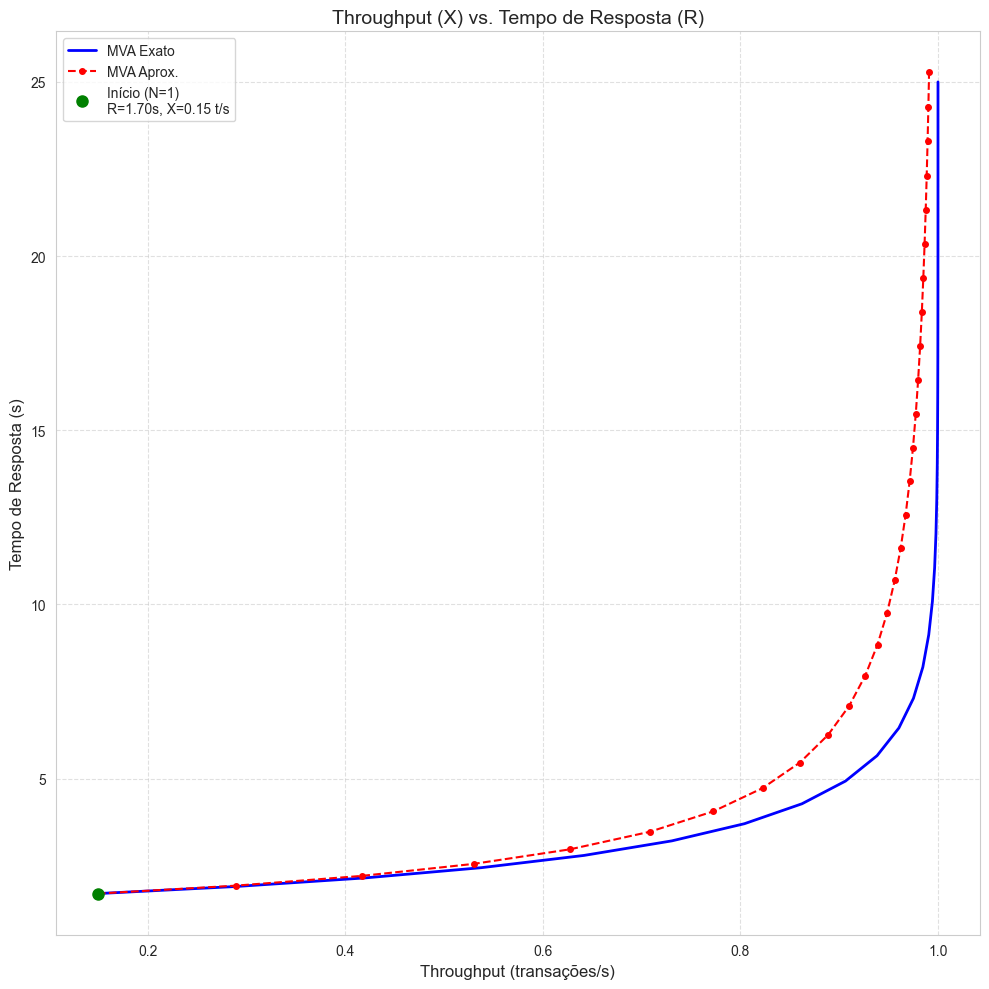

In [ ]:
# ------------------- PLOTS EXEC --------------------------
TOL_APROX = 1e-6 # tolerância para o MVA Aprox.

print("--- Questão 4 ---")
plot_graphs_mva(
    S_demandas=S_questao_4, 
    N_max=N_transacoes_questao_4, 
    Z_think=Z_think_time_questao_4, 
    tol_aprox=TOL_APROX, 
    filename="questao4"
)

print("--- Questão 5 letra j ---")
plot_graphs_mva(
    S_demandas=S_questao_5_j, 
    N_max=N_transacoes_questao_5_j, 
    Z_think=Z_think_time_questao_5_j, 
    tol_aprox=TOL_APROX, 
    filename="questao5j"
)

print("--- Questão 5 letra k ---")
plot_graphs_mva(
    S_demandas=S_questao_5_k, 
    N_max=N_transacoes_questao_5_k, 
    Z_think=Z_think_time_questao_5_k, 
    tol_aprox=tolerancia_questao_5_k, 
    filename="questao5k"
)


D_total (D): 26.550 s
D_max (Gargalo - CPU): 21.000 s (Recurso 2)
Tempo de Pensar (Z): 180.0 s
Ponto de Saturação (N*): (D+Z)/D_max = 9.84


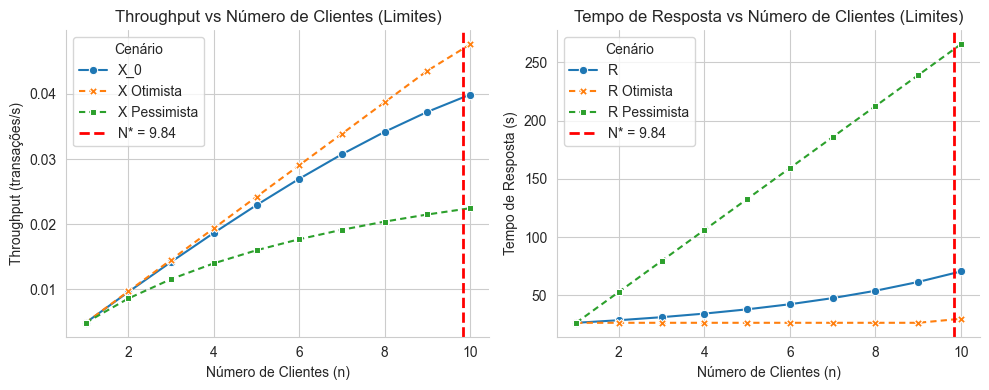

In [3]:
# ------------------- PlOTS PROVA  --------------------------
# Parâmetros Globais
N_TERMINAIS = 10
Z_PENSAR = 180

D_orig = [3.6, 21.0, 1.95]
mva_orig = mva_exato(N_TERMINAIS, D_orig, Z_PENSAR, print_table=False)
plot_performance_graphs(
    mva_orig, 
    D_orig, 
    Z_PENSAR, 
    N_TERMINAIS, 
    "Sistema Batch")

In [3]:
# -------------------------- Parâmetros da Lista 4 (Markov)  --------------------------
state_space = [
        (4,0,0),(3,1,0),(3,0,1),(2,2,0),(2,1,1),
        (2,0,2),(1,3,0),(1,2,1),(1,1,2),(1,0,3),
        (0,4,0),(0,3,1),(0,2,2),(0,1,3),(0,0,4)
    ]

resultado = calculate_system_performance_markov(state_space, 
                                                max_r=4, 
                                                cpu_rate=6.0, 
                                                fast_rate=4.0, 
                                                slow_rate=2.0)

print(f"Utilização da CPU: {resultado['u_cpu']*100:.2f}%")
print("\nProbabilidades por estado:")
for estado, prob in resultado['probabilities']:
    print(f"{estado}: {prob:.5f}")

Utilização da CPU: 57.95%

Probabilidades por estado:
(4, 0, 0): 0.04287
(3, 1, 0): 0.03216
(3, 0, 1): 0.06431
(2, 2, 0): 0.02412
(2, 1, 1): 0.04823
(2, 0, 2): 0.09647
(1, 3, 0): 0.01809
(1, 2, 1): 0.03617
(1, 1, 2): 0.07235
(1, 0, 3): 0.14470
(0, 4, 0): 0.01357
(0, 3, 1): 0.02713
(0, 2, 2): 0.05426
(0, 1, 3): 0.10852
(0, 0, 4): 0.21705
